In [1]:
import pandas as pd 
import numpy as np

In [2]:
import nltk
# nltk.download('all')# download nltk files
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import sent_tokenize, word_tokenize 

In [3]:
import os 
import glob
import re
import time

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# %matplotlib inline


In [6]:
from sklearn.svm import SVC

In [7]:
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchnlp.nn as nlp_nn
import pandas as pd
import numpy as np
import string
import json
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
torch.manual_seed(1)
# from tensorflow import summary
import random
from torch.autograd import Variable
# import tensorflow as tf

In [8]:
def ap(y_pred,y_belong):
  y_pred = np.array(y_pred)
  y_belong = np.array(y_belong)
  y_pred = y_pred.reshape(-1,1)
  y_belong = y_belong.reshape(-1,1)
  arr = np.concatenate((y_pred,y_belong),axis=1)
  
  arr = sorted(arr,key = lambda x:x[0],reverse=True)
  
  ans = 0
  rel = 0
  num = 0
  for i in range(len(y_pred)):
    if arr[i][1] == 1:
      rel = rel+1
      ans += rel/(i+1)
      num = num+1
  return ans/num

In [9]:
def rem_stop(txt):
  return [ c for c in txt if c not in stopwords.words("english")]
stemmer = PorterStemmer()
def word_stemm(txt):
  return [stemmer.stem(w) for w in txt]

In [10]:
xl_files_train = glob.glob("./dataset/Task1/Train/*.xlsx")
xl_files_test = glob.glob("./dataset/Task1/Test/*.xlsx")

In [11]:
xl_files_test

['./dataset/Task1/Test/Loss.xlsx',
 './dataset/Task1/Test/Frustrative_Nonreward.xlsx',
 './dataset/Task1/Test/Sleep_Wakefulness.xlsx',
 './dataset/Task1/Test/Sustained_Threat.xlsx',
 './dataset/Task1/Test/Potential_Threat_Anxiety.xlsx',
 './dataset/Task1/Test/Circadian_Rhythms.xlsx',
 './dataset/Task1/Test/Arousal.xlsx',
 './dataset/Task1/Test/Acute_Threat_Fear.xlsx']

In [12]:
# create labels
labels = {}
revLabels = {}
for i,xl in  enumerate(xl_files_train):
    className = xl.split("/")[-1][:-5]
    labels[className] = i
    revLabels[i] = className

In [13]:
#train dataframes
frames = []
for xl_file in xl_files_train:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_train = pd.concat(frames,ignore_index = True)

In [14]:
#test dataframes
frames = []
for xl_file in xl_files_test:
    df1 = pd.read_excel(xl_file)
    className = xl_file.split("/")[-1][:-5]
    df1['Y'] = labels[className]
    frames.append(df1)
df_test = pd.concat(frames,ignore_index = True)

In [15]:
PUNC_LIST = string.punctuation + string.digits
TOKENIZER = re.compile(r"\w+")
def clean_text(text):
    """
        Removes non-alphabetic characters
    """
    #remove new line and carriage with space
    text = text.replace("\n"," ").replace("\r"," ")
    tmp = str.maketrans(dict.fromkeys(PUNC_LIST," "))
    text = text.translate(tmp)
    # replace single quote with empty 
    tmp  = str.maketrans(dict.fromkeys("'`",""))
    return text.translate(tmp)
def regexTokenize(text):

    return TOKENIZER.findall(clean_text(text))

In [273]:
# pre process the text
stop_words = stopwords.words("english")
def stem(w):
#     return w.lower()
    return stemmer.stem(w)#.lower()
cols = ['title','abstract']
for col in cols :
    df_train['c_'+col] = df_train[col].apply(lambda x: " ".join([stem(i) for i in regexTokenize(x) if i not in stop_words]))
    df_test['c_'+col] = df_test[col].apply(lambda x: " ".join([stem(i) for i in regexTokenize(x) if i not in stop_words]))

In [274]:
# concatenate the entire text
df_train['inp'] =  df_train['c_title'] + df_train['c_abstract']
df_test['inp'] = df_test['c_title']  + df_test['c_abstract']
# c_title = df_train[['c_title','pmid']].values

In [275]:
x_train = df_train['inp'].values

In [276]:
tfidf = TfidfVectorizer()#, tokenizer=regexTokenize)

In [277]:
df_test.columns 

Index(['pmid', 'title', 'abstract', 'Belongs to RDoC construct?',
       'Relevant Context', 'Y', 'c_title', 'c_abstract', 'inp', 'Belongs'],
      dtype='object')

In [278]:
# frequency analysis
voc = {}
for row in x_train:
    for w in row.split():
        if w in voc : 
            voc[w] += 1
        else:
            voc[w] = 1

In [279]:
freqList = []
v= 1000
label = []
for k in voc.keys():
        freqList.append(voc[k])
        label.append(k)
        if voc[k] > 400:
            print(k,voc[k])

sleep 513


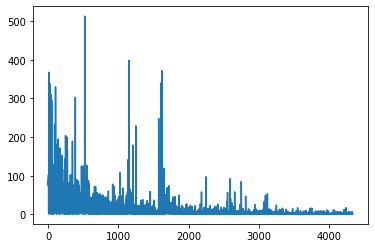

In [280]:
plt.plot(freqList)

In [281]:
x_train = tfidf.fit_transform(x_train).toarray()

In [282]:
y_train = df_train['Y'].values

In [283]:
x_test = df_test['inp'].values
x_test = tfidf.transform(x_test).toarray()
df_test['Belongs'] = df_test['Belongs to RDoC construct?']

In [284]:
# gdf.groups
gdf = df_test.groupby('Y')
construct_test = {}
for i in range(8):
  construct_test[i]= df_test.iloc[gdf.groups[i]]

In [285]:
cw = [28,21,48,18,27,47,38,39]
ncw = [ np.exp(-(i/sum(cw))) for i in cw]
tcw = [ np.exp((i/sum(cw))) for i in cw]
sftmax = { i:e/ sum(ncw) for i,e in enumerate(ncw)}
tsftmax = { i:e/ sum(tcw) for i,e in enumerate(tcw)}
siminv={ i:e/ sum(cw) for i,e in enumerate(cw)}

In [295]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |      Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a 

In [297]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimator=200,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [286]:
# # USING RANDOM FOREST CLASSIFIER
# from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier(bootstrap=True,n_estimators=200,criterion="gini",random_state = 47,max_depth = 3,class_weight=siminv)
# svmc = SVC(gamma = 0.01,C= 0.25,probability = True,shrinking =True,class_weight=tsftmax,break_ties=True, kernel="rbf"  ,decision_function_shape = 'ovr',random_state = 47)

In [302]:
# USING RANDOM FOREST CLASSIFIER
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimator=200)
rfc = RandomForestClassifier(bootstrap=True,oob_score = True,n_estimators=200,criterion="gini",random_state = 47,max_depth = 3,class_weight=siminv)
svmc = SVC(gamma = 0.1512,C= 0.25,probability = True,shrinking =True,class_weight=tsftmax,break_ties=True, kernel="rbf"  ,decision_function_shape = 'ovr',random_state = 47)
map_list = []
estimators = [rfc,svmc,xgb]
for model in estimators:
    print(model.fit(x_train, y_train))
class_count = {}
err = {}
for i,model in enumerate(estimators):
  aps = 0
  err[i] = {}
  for cl_ in construct_test.keys():
    X_test = tfidf.transform(construct_test[cl_]['inp']).toarray()
    y_pred = model.predict_proba(X_test)[:,cl_]
    y_belongs = np.array(construct_test[cl_]['Belongs'].values).reshape(len(X_test),1)
    t = ap(y_pred,y_belongs)
    err[i][cl_] = round( t, 2)
    aps += t
  print("=====")
  map_list.append(round(aps/8,2))
print("MAP",list(map(lambda x:round(x,5),map_list)))
st = "Class Name\t\t\t"+ "\t\t".join([str(i) for i  in range(len(err.keys()))])
print(st)
for cl_ in construct_test.keys():
    padd = "\t\t"
    if len(revLabels[cl_]) < 15:
        padd += "\t\t"
    if len(revLabels[cl_]) > 22:
        padd = "\t"
    st = revLabels[cl_]+padd+"\t\t".join([ str(round(err[j][cl_],4)) for j in range(len(err.keys()))])
    print(st)
        

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 0.10526315789473684,
                                     1: 0.07894736842105263,
                                     2: 0.18045112781954886,
                                     3: 0.06766917293233082,
                                     4: 0.10150375939849623,
                                     5: 0.17669172932330826,
                                     6: 0.14285714285714285,
                                     7: 0.14661654135338345},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=47, verbose=0,
                       warm_st